# Linear Regression and Neural Network models
## Step by step plan:

Data ingestion<br>

Data wrangling and feature engineering
- Outlier removal<br>
- Tokenization and cleanup of job titles<br>
- Creation of dummies for all categorical variables<br>

*Train test split*<br>

Post split wrangling<br>
- Feature selection and database cleanup<br>
- Target variable normalization<br>

### Model creation and evaluation
- Parameter evaluation<br>
- Actual vs predicted target variable analysis<br>
- Residuals analysis<br>

### Created models:
- One linear model<br>
- One linear model using exclusively significant independent variables<br>
- One neural network model<br>
- One linear model using PCA (some exploratory analysis is done for PCA results)<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox, shapiro, normaltest, kstest, pearsonr
from scipy.special import inv_boxcox
from itertools import combinations

In [2]:
sns.set() # makes all charts look better by default

## Data Ingestion

In [3]:
aijobs = pd.read_csv(r'https://ai-jobs.net/salaries/download/salaries.csv')
# Last accessed at 2024-03-16

In [4]:
aijobs # first look at the data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,Data Scientist,86218,USD,86218,CA,0,CA,M
1,2024,MI,FT,Data Scientist,68975,USD,68975,CA,0,CA,M
2,2024,SE,FT,AI Architect,285000,USD,285000,US,0,US,M
3,2024,SE,FT,AI Architect,153400,USD,153400,US,0,US,M
4,2024,SE,FT,Data Scientist,101763,USD,101763,CA,0,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
14486,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
14487,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
14488,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
14489,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


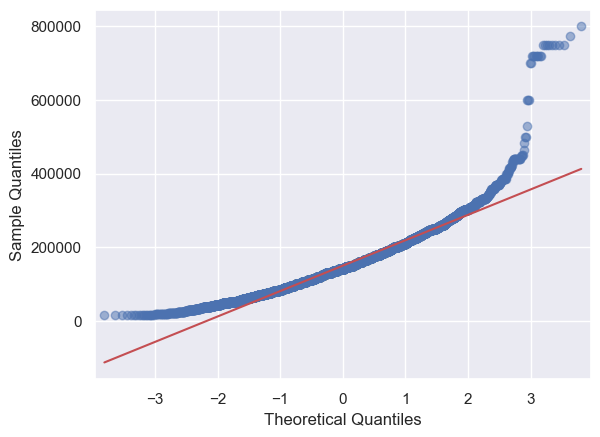

In [5]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

# Common data wrangling
These steps would be equally done for train and test bases with no population or sampled information, only individual ones, so no data leakage will occur if done now.

### Outlier removal

In [6]:
# The first outliers are extremely out of touch with the remainder of the database.
# They will skew the results too much and must be removed.
# According to Hair, from 2.5 to 4 standards deviations might be used to remove outliers.
# Visually, 4 deviations cover the worst cases.

mean = aijobs['salary_in_usd'].mean()
std = mean = aijobs['salary_in_usd'].std()
outmax = mean + 4 * std
print(outmax)
outliers = aijobs[aijobs['salary_in_usd'] > outmax].index
print(outliers)

aijobs.drop(outliers, inplace=True)
aijobs.reset_index(drop=True, inplace=True)
aijobs.sort_values('salary_in_usd', ascending=False).head()

345026.0898475235
Index([   10,   100,   118,   145,   147,   259,   283,   307,   582,   584,
       ...
       12785, 13128, 13143, 13322, 14216, 14221, 14273, 14418, 14483, 14486],
      dtype='int64', length=141)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
278,2024,SE,FT,Research Scientist,345000,USD,345000,US,0,US,M
9601,2023,SE,FT,Research Scientist,345000,USD,345000,US,0,US,M
10697,2023,SE,FT,Computer Vision Engineer,342810,USD,342810,US,0,US,M
2245,2024,SE,FT,Data Analytics Lead,342400,USD,342400,US,0,US,M
10795,2023,SE,FT,Machine Learning Engineer,342300,USD,342300,US,0,US,L


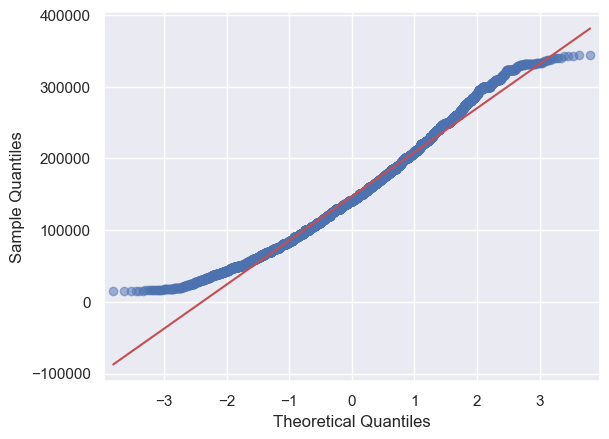

In [7]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

In [8]:
# There is no value in local currency salaries as they're not scaled.
# Salary in USD conveys the same useful information in a scaled manner.
aijobs.drop('salary', axis=1, inplace=True)

In [9]:
# An interesting variable to research
aijobs['work_abroad'] = aijobs['employee_residence'] != aijobs['company_location']
aijobs['work_abroad'] = aijobs['work_abroad'].astype(int)
aijobs.tail(10)

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,work_abroad
14340,2020,MI,FT,Data Engineer,USD,130800,ES,100,US,M,1
14341,2020,SE,FT,Machine Learning Engineer,EUR,45618,HR,100,HR,S,0
14342,2021,SE,FT,Director of Data Science,USD,168000,JP,0,JP,S,0
14343,2021,MI,FT,Data Scientist,SGD,119059,SG,100,IL,M,1
14344,2021,MI,FT,Data Engineer,EUR,28369,MT,50,MT,L,0
14345,2021,SE,FT,Data Specialist,USD,165000,US,100,US,L,0
14346,2021,MI,FT,Principal Data Scientist,USD,151000,US,100,US,L,0
14347,2020,EN,FT,Data Scientist,USD,105000,US,100,US,S,0
14348,2020,EN,CT,Business Data Analyst,USD,100000,US,100,US,L,0
14349,2021,SE,FT,Data Science Manager,INR,94665,IN,50,IN,L,0


In [10]:
# remote_ratio is categorical; the correct way to interpret those numbers is:
#   0 == On Site (less than 20% remote)
#  50 == Partially remote/hybird
# 100 == Fully remote (more than 80% remote)
# therefore using it as numerical would be creating a spurious relationship.
# It has to be dummified and will be switched for easier interpretation.

aijobs.loc[aijobs['remote_ratio'] == 0, 'remote_ratio'] = 'On_Site'
aijobs.loc[aijobs['remote_ratio'] == 50, 'remote_ratio'] = 'Hybrid'
aijobs.loc[aijobs['remote_ratio'] == 100, 'remote_ratio'] = 'Remote'

aijobs['remote_ratio']

0        On_Site
1        On_Site
2        On_Site
3        On_Site
4        On_Site
          ...   
14345     Remote
14346     Remote
14347     Remote
14348     Remote
14349     Hybrid
Name: remote_ratio, Length: 14350, dtype: object

In [11]:
# Categorical columns will receive appropriate treatment
categorical_columns = ['experience_level', 'employment_type', 'salary_currency', 'employee_residence', 'remote_ratio', 
                       'company_location', 'company_size']

## Feature Engineering

In [12]:
# Quick look at job titles. This will receive a quick NLP method for processing.
print(len(aijobs['job_title'].unique()), "different job titles \n")
print(aijobs['job_title'].unique())

148 different job titles 

['Data Scientist' 'AI Architect' 'Data Analyst' 'AI Engineer'
 'Data Architect' 'Data Engineer' 'Data Integration Specialist'
 'Data Science' 'Robotics Engineer' 'Research Analyst' 'Applied Scientist'
 'BI Developer' 'Business Intelligence Analyst'
 'Machine Learning Engineer' 'Research Scientist' 'Head of Data'
 'Data Science Manager' 'Data Modeler' 'Business Intelligence Engineer'
 'Cloud Database Engineer' 'Machine Learning Scientist' 'Data Specialist'
 'Data Operations Analyst' 'Data Developer' 'Research Engineer'
 'Data Science Analyst' 'Data Science Practitioner'
 'Data Management Analyst' 'Analytics Engineer' 'Data Science Consultant'
 'BI Data Analyst' 'Applied Data Scientist' 'Business Intelligence'
 'Insight Analyst' 'Data Quality Engineer' 'BI Analyst' 'Data Manager'
 'Computational Biologist' 'AI Research Scientist' 'MLOps Engineer'
 'Big Data Engineer' 'Business Intelligence Manager' 'Prompt Engineer'
 'Data Integration Engineer' 'Data Analytics 

In [13]:
# Work on the terms contained in job titles.
terms = []
for title in aijobs['job_title'].unique():
    for word in title.split():
        terms.append(word)
terms = sorted(set(terms))
print(len(terms), "different terms in these titles \n")
print(terms)

77 different terms in these titles 

['&', 'AI', 'AWS', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Autonomous', 'Azure', 'BI', 'Big', 'Biologist', 'Business', 'Cloud', 'Compliance', 'Computational', 'Computer', 'Consultant', 'Data', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Director', 'ETL', 'Engineer', 'Finance', 'Financial', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Intelligence', 'Lead', 'Learning', 'ML', 'MLOps', 'Machine', 'Management', 'Manager', 'Managing', 'Marketing', 'Modeler', 'Modeller', 'NLP', 'Operations', 'Ops', 'Owner', 'Pipeline', 'Power', 'Practitioner', 'Principal', 'Product', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Research', 'Researcher', 'Robotics', 'Sales', 'Science', 'Scientist', 'Software', 'Specialist', 'Staff', 'Strategist', 'Strategy', 'Technician', 'Vehicle', 'Vision', 'Visualization', 'of']


In [14]:
stop_words = ['&', 'of', 'Data', 'Learning', 'Consultant', 'Computational', 'Computer', 'Managing', 'Power', 'Sales', 'Tech', 
              'Technician', 'Vehicle', 'Autonomous', 'Compliance', 'DevOps', 'Marketing']
# Justification: '&', 'of' and 'Data' are too generic for this project.
# 'Learning' has two contexts: Machine Learning and Deep Learning, yet both "Machine" and "Deep" are unique to them,
# so there's nothing to be gained from adding it.
# "Autonomous Vehicle Technician" is a job title whose words are all unique, so a single one is enough.
# "Computational Biologist" shares the same issue.
# "Computer Vision" is present in more than one job, but all of them use this same sequence, so it's the same situation.
# All other ones present themselves only at most in a couple of entries and therefore are prone to overfitting.

In [15]:
synonym_terms = ['ML','Machine','MLOps', 'Operations','Business','BI','Intelligence','AWS','Cloud','Azure','Modeller','Modeler',
                 'Engineering','Engineer','Financial','Finance','Researcher','Research','Science','Scientist',
                 'Strategy','Strategist','Management','Manager']

In [16]:
# this uses the same pressupositions as above, but some words will mean the same thing.
synonyms = {'Machine': 'Machine|ML|MLOps',      # ML is short for Machine Learning
            'Operations':'MLOps|Operations',    # Ops is short for Operations
            'Intelligence':'Intelligence|BI',   # BI is short for Business Intelligence (Intelligence is exclusive to BI)
            'Business':'Business|BI',           # For consistency (Business is not exclusive to BI)
            'Cloud':'Cloud|AWS|Azure',          # There is a single instance for AWS and for Azure; both specific cloud tools
            'Modeler':'Modeler|Modeller',       # Typo
            'Engineer':'Engineer|Engineering',
            'Finance':'Finance|Financial',
            'Research':'Research|Researcher',
            'Scientist':'Scientist|Science',
            'Strategist':'Strategist|Strategy',
            'Manager':'Management|Manager'}
# Note: Analyst and Analytics in this context will mean different things.

In [17]:
clean_terms = terms.copy()                                                   # copy method to keep the original list
[clean_terms.remove(term) for term in stop_words if term in clean_terms]     # remove stop words
[clean_terms.remove(term) for term in synonym_terms if term in clean_terms]  # synonyms will be processed differently
print(len(clean_terms), "terms after cleaning\n", len(synonyms), "synonyms\n ", len(clean_terms)+len(synonyms), "total terms\n")
print(clean_terms)

38 terms after cleaning
 12 synonyms
  50 total terms

['AI', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Big', 'Biologist', 'Database', 'Decision', 'Deep', 'Developer', 'Director', 'ETL', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Lead', 'NLP', 'Ops', 'Owner', 'Pipeline', 'Practitioner', 'Principal', 'Product', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Robotics', 'Software', 'Specialist', 'Staff', 'Vision', 'Visualization']


In [18]:
# dummization for all chosen job keywords
for job_string in clean_terms:
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(job_string, case=False).astype(int)
for job_string in synonyms.keys():
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(f'{synonyms[job_string]}', case=False).astype(int)
aijobs.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,job_name_Intelligence,job_name_Business,job_name_Cloud,job_name_Modeler,job_name_Engineer,job_name_Finance,job_name_Research,job_name_Scientist,job_name_Strategist,job_name_Manager
0,2024,MI,FT,Data Scientist,USD,86218,CA,On_Site,CA,M,...,0,0,0,0,0,0,0,1,0,0
1,2024,MI,FT,Data Scientist,USD,68975,CA,On_Site,CA,M,...,0,0,0,0,0,0,0,1,0,0
2,2024,SE,FT,AI Architect,USD,285000,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
3,2024,SE,FT,AI Architect,USD,153400,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
4,2024,SE,FT,Data Scientist,USD,101763,CA,On_Site,CA,M,...,0,0,0,0,0,0,0,1,0,0


In [19]:
# dummization for all other categorical columns
df_dummies = pd.get_dummies(aijobs[categorical_columns], dtype=int)
aijobs = pd.concat([aijobs, df_dummies], axis=1)
aijobs.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_location_ZA,company_size_L,company_size_M,company_size_S
0,2024,MI,FT,Data Scientist,USD,86218,CA,On_Site,CA,M,...,0,0,0,0,0,0,0,0,1,0
1,2024,MI,FT,Data Scientist,USD,68975,CA,On_Site,CA,M,...,0,0,0,0,0,0,0,0,1,0
2,2024,SE,FT,AI Architect,USD,285000,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
3,2024,SE,FT,AI Architect,USD,153400,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
4,2024,SE,FT,Data Scientist,USD,101763,CA,On_Site,CA,M,...,0,0,0,0,0,0,0,0,1,0


In [20]:
aijobs[categorical_columns].describe().loc['unique']

experience_level       4
employment_type        4
salary_currency       22
employee_residence    87
remote_ratio           3
company_location      77
company_size           3
Name: unique, dtype: object

In [21]:
# To establish the features, categorical columns that are not dummies will need to be removed. Target variable too.

X_vars = aijobs.columns.tolist()
[X_vars.remove(col) for col in categorical_columns if col in X_vars]
X_vars.remove('job_title')
X_vars.remove('salary_in_usd')
X_vars

['work_year',
 'work_abroad',
 'job_name_AI',
 'job_name_Admin',
 'job_name_Analyst',
 'job_name_Analytics',
 'job_name_Applied',
 'job_name_Architect',
 'job_name_Associate',
 'job_name_Big',
 'job_name_Biologist',
 'job_name_Database',
 'job_name_Decision',
 'job_name_Deep',
 'job_name_Developer',
 'job_name_Director',
 'job_name_ETL',
 'job_name_Head',
 'job_name_Infrastructure',
 'job_name_Insight',
 'job_name_Integration',
 'job_name_Lead',
 'job_name_NLP',
 'job_name_Ops',
 'job_name_Owner',
 'job_name_Pipeline',
 'job_name_Practitioner',
 'job_name_Principal',
 'job_name_Product',
 'job_name_Programmer',
 'job_name_Prompt',
 'job_name_Quality',
 'job_name_Quantitative',
 'job_name_Reporting',
 'job_name_Robotics',
 'job_name_Software',
 'job_name_Specialist',
 'job_name_Staff',
 'job_name_Vision',
 'job_name_Visualization',
 'job_name_Machine',
 'job_name_Operations',
 'job_name_Intelligence',
 'job_name_Business',
 'job_name_Cloud',
 'job_name_Modeler',
 'job_name_Engineer',
 '

In [22]:
# Comprehensive dummies will need one instance removed.
# They could be picked by hand, but the algorithm below selects the most popular for deletion.

c_dummies = aijobs[['experience_level_EN', 'experience_level_MI', 'experience_level_SE', 'experience_level_EX']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['employment_type_FL', 'employment_type_PT', 'employment_type_CT', 'employment_type_FT']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['remote_ratio_Remote', 'remote_ratio_Hybrid', 'remote_ratio_On_Site']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['company_size_S', 'company_size_M', 'company_size_L']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

# These larger dummies will be implied in the intercept.
X_vars.remove('salary_currency_USD')
X_vars.remove('employee_residence_US')
X_vars.remove('company_location_US')

X_vars

['work_year',
 'work_abroad',
 'job_name_AI',
 'job_name_Admin',
 'job_name_Analyst',
 'job_name_Analytics',
 'job_name_Applied',
 'job_name_Architect',
 'job_name_Associate',
 'job_name_Big',
 'job_name_Biologist',
 'job_name_Database',
 'job_name_Decision',
 'job_name_Deep',
 'job_name_Developer',
 'job_name_Director',
 'job_name_ETL',
 'job_name_Head',
 'job_name_Infrastructure',
 'job_name_Insight',
 'job_name_Integration',
 'job_name_Lead',
 'job_name_NLP',
 'job_name_Ops',
 'job_name_Owner',
 'job_name_Pipeline',
 'job_name_Practitioner',
 'job_name_Principal',
 'job_name_Product',
 'job_name_Programmer',
 'job_name_Prompt',
 'job_name_Quality',
 'job_name_Quantitative',
 'job_name_Reporting',
 'job_name_Robotics',
 'job_name_Software',
 'job_name_Specialist',
 'job_name_Staff',
 'job_name_Vision',
 'job_name_Visualization',
 'job_name_Machine',
 'job_name_Operations',
 'job_name_Intelligence',
 'job_name_Business',
 'job_name_Cloud',
 'job_name_Modeler',
 'job_name_Engineer',
 '

# Splitting and working the data before model fit

In [23]:
X_train, X_test, y_train, y_test = train_test_split(aijobs[X_vars], aijobs['salary_in_usd'], test_size=0.2, random_state=42)

In [24]:
X_train

,work_year,work_abroad,job_name_AI,job_name_Admin,job_name_Analyst,job_name_Analytics,job_name_Applied,job_name_Architect,job_name_Associate,job_name_Big,...,company_location_SE,company_location_SG,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_VN,company_location_ZA,company_size_L,company_size_S
7627,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13498,2022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4398,2023,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12363,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12139,2023,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13418,2022,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5390,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,2024,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# To delete columns with too few instances in order to avoid overfitting
# Hair says 5 is a minimum threshold

def del_vars(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, printing=False):
    """
    This function deletes all columns in training base that have too few instances and will result in overfitting
    It also deletes every row that had an instance in such columns in order to prevent assumptions implied in the intecept
    As these variables are rendered unworkable, they are also deleted from test base (no information leak happens)
    Every row removed from independent variables bases (X) is also removed from the dependent variable array (y).
    """
    
    if printing == True:
        print("Before:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    deletions = 1 #just to enter the loop
    train_dropped = []
    while deletions > 0:
        deletions = X_train.shape[0] # store the dataframe size for later comparison
        X_sum = X_train.sum()
        exclusion_list = X_sum[X_sum < 5].index # create the exclusion column list

        # deleting all rows with any positive value in those variables
        X_delete = X_train[exclusion_list].sum(axis=1)
        rows_to_delete = X_delete[X_delete != 0]
        X_train.drop(rows_to_delete.index, inplace=True)
        
        [train_dropped.append(item) for item in rows_to_delete.index] # list all deleted rows for later consistency wity y array
        deletions = deletions - X_train.shape[0] # difference from previous dataframe size
        if printing == True:
            print('Rows deleted:', deletions) # deleted rows in this loop
            print('Columns dropped:', len(exclusion_list)) # cumulative columns to be deleted
        # loop until there are no more deleted rows
        
    X_train.drop(exclusion_list, axis=1, inplace=True) # dropping columns from train base now
    
    test_deletion = X_test[exclusion_list].sum(axis=1) # filter a dataframe by select all exclusion rows and their sum
    test_dropped = test_deletion[test_deletion > 0].index # finding all rows with a positive value on any of those dummies
    X_test.drop(test_dropped, inplace=True) # dropping unworkable test rows
    X_test.drop(exclusion_list, axis=1, inplace=True) # dropping columns from test base
    
    # shaping dependent variable arrays to match independent variables dataframes
    y_train.drop(train_dropped, inplace=True)
    y_test.drop(test_dropped, inplace=True)
    if printing == True:
        print("After:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [26]:
del_vars(printing=True)

Before: (11480, 245) (11480,) (2870, 245) (2870,)
Rows deleted: 127
Columns dropped: 116
Rows deleted: 30
Columns dropped: 129
Rows deleted: 9
Columns dropped: 133
Rows deleted: 0
Columns dropped: 133
After: (11314, 112) (11314,) (2826, 112) (2826,)


## Box-Cox transformation

Best Lambda Value: 0.5474


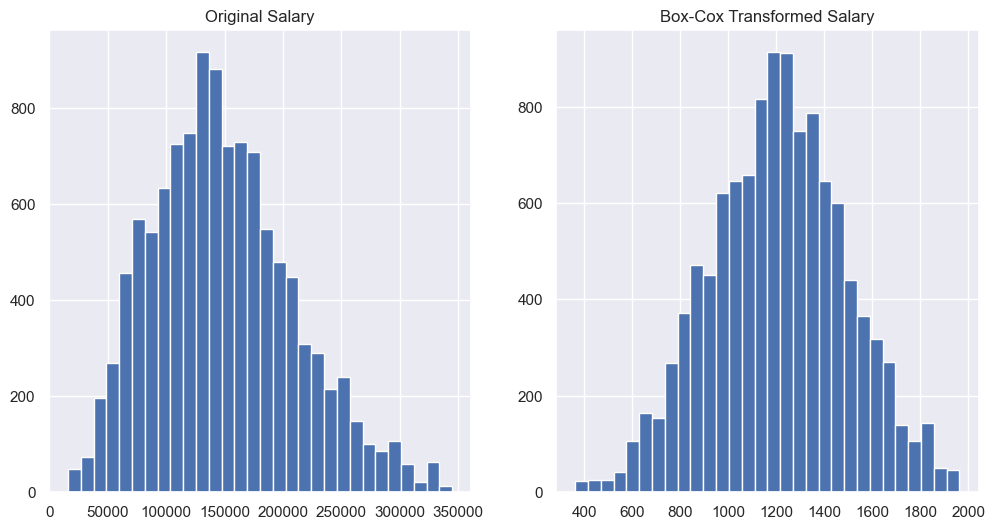

Normal test: NormaltestResult(statistic=34.740799653957446, pvalue=2.8584539935323684e-08)
Shapiro-Wilk test: ShapiroResult(statistic=0.9981799125671387, pvalue=2.7317054174247346e-10)
Kolmogorov-Smirnov test: KstestResult(statistic=1.0, pvalue=0.0, statistic_location=361.5150661615924, statistic_sign=-1)


C:\Users\Captain\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [27]:
# fit the lambda and transform the train dependent variable
y_train_original = y_train.copy()
y_train_vals, lmbda = boxcox(y_train)
print(f'Best Lambda Value: {lmbda:.4f}')
y_train = pd.Series(y_train_vals, index=y_train.index, name='transformed_salary')

# transform the test dependent variable

y_test_original = y_test.copy()
y_test_vals = boxcox(y_test, lmbda)
y_test = pd.Series(y_test_vals, index=y_test.index, name='transformed_salary')

# plot

plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 2, 1)
plt.hist(y_train_original, bins=30)
plt.title('Original Salary')

# Transformed
plt.subplot(1, 2, 2)
plt.hist(y_train, bins=30)
plt.title('Box-Cox Transformed Salary')

plt.show()

print('Normal test:', normaltest(y_train))
print('Shapiro-Wilk test:', shapiro(y_train))
print('Kolmogorov-Smirnov test:', kstest(y_train, "norm"))

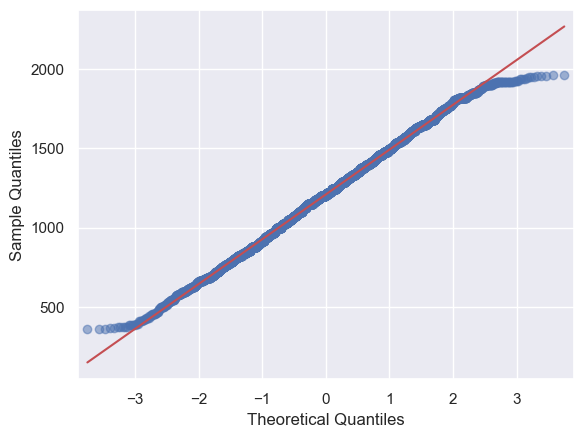

In [28]:
sm.qqplot(y_train, line='s', alpha=0.5)
plt.show()

# Starting the Model

In [29]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [30]:
# Create a model and displaying the summary
MRL_model = sm.OLS(y_train, X_train).fit()
MRL_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     78.86
Date:                Sun, 17 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:50:46   Log-Likelihood:                -76772.
No. Observations:               11314   AIC:                         1.538e+05
Df Residuals:                   11208   BIC:                         1.545e+05
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -1.153e+04   6661.395     -1.731      0.084   -2.46e+04    1528.789
work_year                   6.2568      3.292      1.900      0.057      -0.197      12.710
work_abroad                13.5508     60.093      0.225      0.822    -104.242     131.344
job_name_AI               110.5078     19.945      5.541      0.000      71.413     149.603
job_name_Analyst           -0.5570     17.589     -0.032      0.975     -35.034      33.920
job_name_Analytics         22.1354     11.750      1.884      0.060      -0.897      45.168
job_name_Applied          133.9618     14.219      9.421      0.000     106.089     161.835
job_name_Architect        179.0058     21.175      8.454      0.000     137.498     220.513
job_name_Associate        -17.3349    101.636     -0.171      0.865    -216.559     181.889
job_name_Big               27.7298     70.230      0.395      0.693    -109.933     165.392
job_name_Database        -395.3992    137.223     -2.881      0.004    -664.381    -126.417
job_name_Decision          67.4920     39.509      1.708      0.088      -9.953     144.937
job_name_Deep             259.5639     68.597      3.784      0.000     125.102     394.026
job_name_Developer         -0.0027     24.865     -0.000      1.000     -48.742      48.737
job_name_Director         194.4585     40.627      4.786      0.000     114.822     274.095
job_name_ETL               -6.8128     51.062     -0.133      0.894    -106.904      93.278
job_name_Head             302.2315     37.624      8.033      0.000     228.482     375.981
job_name_Infrastructure    24.1577     37.752      0.640      0.522     -49.844      98.159
job_name_Insight          -68.0501     72.407     -0.940      0.347    -209.981      73.881
job_name_Integration       50.4166     40.275      1.252      0.211     -28.529     129.362
job_name_Lead             114.9770     26.742      4.299      0.000      62.557     167.397
job_name_NLP              144.9210     74.289      1.951      0.051      -0.699     290.541
job_name_Ops                4.8639     57.556      0.085      0.933    -107.957     117.685
job_name_Practitioner     -70.1872     57.680     -1.217      0.224    -183.250      42.876
job_name_Principal        189.6846     58.635      3.235      0.001      74.750     304.619
job_name_Product          151.0093     41.370      3.650      0.000      69.917     232.102
job_name_Prompt           103.7829     65.416      1.586      0.113     -24.444     232.010
job_name_Quality         -172.8836     47.222     -3.661      0.000    -265.446     -80.321
job_name_Robotics          27.6509     68.749      0.402      0.688    -107.108     162.410
job_name_Software          81.5821     49.653      1.643      0.100     -15.747     178.911
job_name_Specialist       -55.0865     28.132  

In [31]:
pvalues = MRL_model.pvalues
print('Significant coefficients:', pvalues[pvalues <= 0.05].count())
print('Coefficients NOT significant:', pvalues[pvalues > 0.05].count(), '\n')
print(MRL_model.pvalues.sort_values().to_string())

Significant coefficients: 49
Coefficients NOT significant: 64 

experience_level_EN        4.303591e-141
experience_level_MI        6.107919e-128
job_name_Machine           6.372520e-105
salary_currency_GBP         6.058205e-43
job_name_Research           6.765150e-41
job_name_Scientist          1.322416e-25
job_name_Applied            5.341668e-21
job_name_Architect          3.176174e-17
job_name_Engineer           5.898327e-17
job_name_Head               1.046986e-15
experience_level_EX         5.087116e-12
salary_currency_EUR         2.218530e-11
employee_residence_CO       2.236492e-11
company_location_CO         2.236492e-11
job_name_AI                 3.080755e-08
salary_currency_AUD         2.624910e-07
job_name_Director           1.719396e-06
salary_currency_CAD         2.714049e-06
salary_currency_INR         5.089722e-06
job_name_Lead               1.726960e-05
employee_residence_LV       5.093343e-05
company_location_LV         5.093343e-05
company_location_ZA         6.1586

In [32]:
y_pred = MRL_model.predict(X_test)

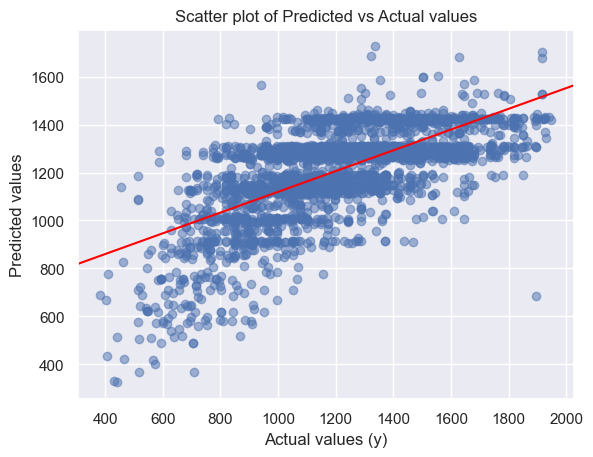

Model R squared: 0.4249

Prediction R squared: 0.4272 p-value: 0.0000

y = 0.4334x +686.3


In [33]:
# Create a scatter plot
m, b = np.polyfit(y_test, y_pred, deg=1)
R_2 = pearsonr(y_test, y_pred)

plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Scatter plot of Predicted vs Actual values')
plt.xlabel('Actual values (y)')
plt.ylabel('Predicted values')
plt.axline(xy1=(y_test.mean(), y_test.mean() * m + b), slope=m, color='red')

plt.show()

print(f'Model R squared: {MRL_model.rsquared:.4f}\n')
print(f'Prediction R squared: {R_2[0]**2:.4f} p-value: {R_2[1]:.4f}')
print(f'\ny = {m:.4f}x {b:+.1f}')

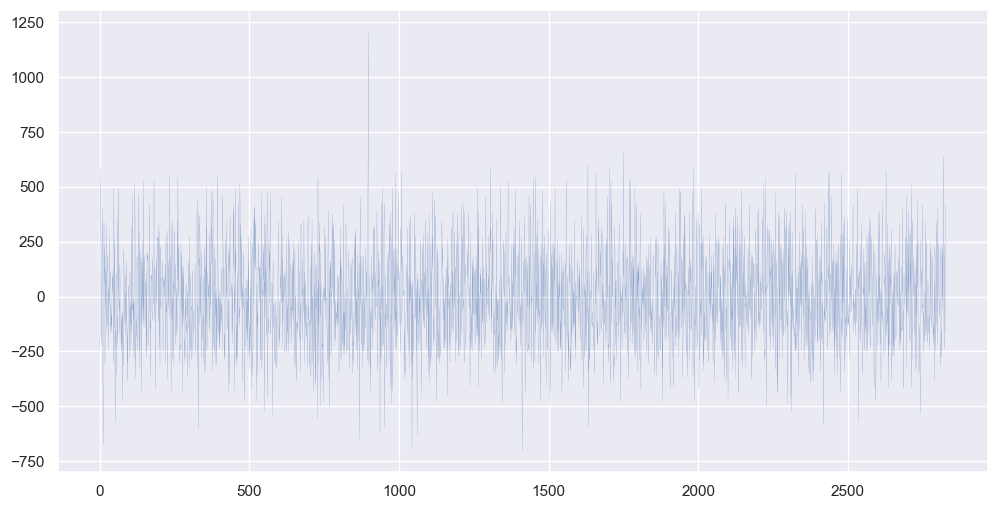

Residuals mean: -5.462276; Standard Deviation: 216.17
 Durbin Watson: 2.01


In [34]:
# Plotting the residuals
residuals = (y_test - y_pred).values

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(residuals, linewidth=0.1)
plt.show()
print(f'Residuals mean: {residuals.mean():.6f}; Standard Deviation: {residuals.std():.2f}'
    f'\n Durbin Watson: {durbin_watson(residuals):.2f}')
# closer to 2 means no autocorrelation; 0 or 4 means autocorrelation

ShapiroResult(statistic=0.9952036142349243, pvalue=6.295860544014431e-08)
NormaltestResult(statistic=31.385792554737307, pvalue=1.5298954099985656e-07)
KstestResult(statistic=0.5297027020860533, pvalue=0.0, statistic_location=-3.3705095966829504, statistic_sign=1)


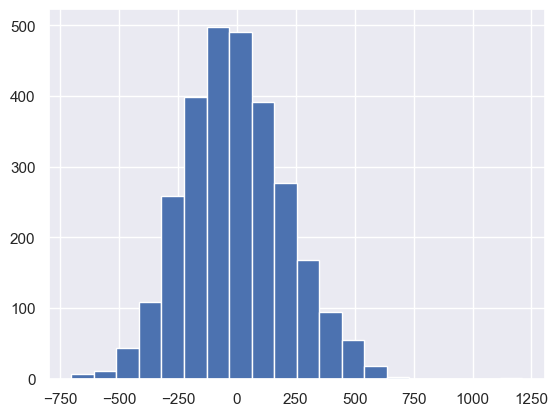

In [35]:
# tests and histogram to look at residuals' normality
print(shapiro(residuals))
print(normaltest(residuals))
print(kstest(residuals, "norm"))
plt.hist(residuals, bins=20)
plt.show()

## SIGNIFICANT ONLY

In [36]:
print('Intercept significance:', MRL_model.pvalues[MRL_model.pvalues.index == 'const'][0])

Intercept significance: 0.08353711480913469


In [39]:
X_train_step = X_train.copy()
X_test_step = X_test.copy()
y_train_step = y_train.copy()
y_test_step = y_test.copy()

X_train_step = sm.add_constant(X_train_step)
X_test_step = sm.add_constant(X_test_step)

In [40]:
# Create a model and displaying the summary

# A few variables look like they still have high p-values even in an isolated model.
# Loop until only significant variables are present
NOT_significant_vars = [1] # creation of a non empty list to enter the loop
while NOT_significant_vars != []:
    # The model is created, but a new one using only the previously resulting significant variables 
    # did not render a new model with all variables resulting significant.
    # A stepwise deletion for these variables will be done here until that happens.
    del_vars(X_train=X_train_step, X_test=X_test_step, y_train=y_train_step, y_test=y_test_step)
    MRL_model_step = sm.OLS(y_train_step, X_train_step).fit()
    y_pred_step = MRL_model_step.predict(X_test_step)

    # Bring all not significant variables into a single list
    NOT_significant_vars = MRL_model_step.pvalues[MRL_model_step.pvalues > 0.05]
    NOT_significant_vars = list(NOT_significant_vars.index)

    # remove the intercept from this list so it isn't removed from the model
    if 'const' in NOT_significant_vars:
        NOT_significant_vars.remove('const')

    X_train_step.drop(NOT_significant_vars, axis=1, inplace=True)
    X_test_step.drop(NOT_significant_vars, axis=1, inplace=True)

MRL_model_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     202.4
Date:                Sun, 17 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:55:36   Log-Likelihood:                -76899.
No. Observations:               11314   AIC:                         1.539e+05
Df Residuals:                   11274   BIC:                         1.542e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1129.4459      5.231    215.909      0.000    1119.192    1139.700
job_name_AI             103.8218     19.779      5.249      0.000      65.052     142.591
job_name_Applied        127.3319     13.149      9.684      0.000     101.558     153.105
job_name_Architect      181.6341     13.357     13.598      0.000     155.452     207.816
job_name_Database      -279.1969    130.932     -2.132      0.033    -535.846     -22.548
job_name_Deep           275.4826     69.066      3.989      0.000     140.102     410.863
job_name_Director       197.3289     40.548      4.867      0.000     117.848     276.810
job_name_Head           289.9860     35.353      8.203      0.000     220.689     359.283
job_name_Lead           120.1550     25.753      4.666      0.000      69.674     170.636
job_name_Principal      194.2269     58.501      3.320      0.001      79.556     308.898
job_name_Product        147.2279     41.197      3.574      0.000      66.476     227.980
job_name_Quality       -180.0524     47.529     -3.788      0.000    -273.218     -86.886
job_name_Vision         151.1624     43.763      3.454      0.001      65.379     236.946
job_name_Machine        147.2558      6.622     22.237      0.000     134.275     160.236
job_name_Operations     -81.8238     27.730     -2.951      0.003    -136.180     -27.468
job_name_Cloud          219.2745    109.163      2.009      0.045       5.295     433.254
job_name_Engineer       145.7335      5.843     24.941      0.000     134.280     157.187
job_name_Research       117.8782      8.796     13.401      0.000     100.636     135.120
job_name_Scientist      175.5532      5.919     29.659      0.000     163.951     187.155
job_name_Manager         57.8559     12.601      4.591      0.000      33.156      82.556
experience_level_EN    -216.8849      8.378    -25.887      0.000    -233.307    -200.463
experience_level_EX      96.6700     13.939      6.935      0.000      69.348     123.992
experience_level_MI    -124.0128      5.052    -24.550      0.000    -133.915    -114.111
employment_type_FL     -339.4713     91.938     -3.692      0.000    -519.686    -159.256
salary_currency_AUD    -284.9374     66.117     -4.310      0.000    -414.538    -155.337
salary_currency_CAD    -218.1634     34.776     -6.273      0.000    -286.330    -149.997
salary_currency_EUR    -440.1040     13.406    -32.830      0.000    -466.381    -413.827
salary_currency_GBP    -293.7761     10.955    -26.817      0.000    -315.249    -272.303
salary_currency_INR    -378.2169     68.517     -5.520      0.000    -512.521    -243.913
salary_currency_PLN    -559.9623     97.239     -5.759      0.000    -750.568    -369.356
employee_residence_AR  -435.3898     68.889     -6.320      0.000    -570.423    -300.356
employee_residence_CO  

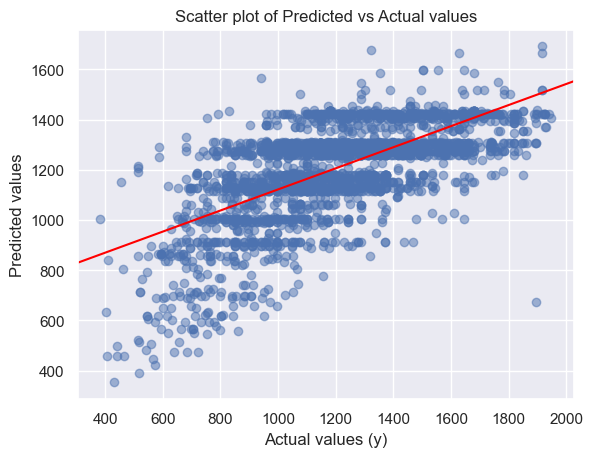

Model R squared: 0.4118

Prediction R squared: 0.4161 p-value: 0.0000

y = 0.4202x +701.7


In [41]:
# Create a scatter plot
m, b = np.polyfit(y_test_step, y_pred_step, deg=1)

plt.scatter(y_test_step, y_pred_step, alpha=0.5)
plt.title('Scatter plot of Predicted vs Actual values')
plt.xlabel('Actual values (y)')
plt.ylabel('Predicted values')
plt.axline(xy1=(y_test_step.mean(), y_test_step.mean() * m + b), slope=m, color='red')
plt.show()

print(f'Model R squared: {MRL_model_step.rsquared:.4f}\n')
R_2_step = pearsonr(y_test_step, y_pred_step)
print(f'Prediction R squared: {R_2_step[0]**2:.4f} p-value: {R_2_step[1]:.4f}')
print(f'\ny = {m:.4f}x {b:+.1f}')

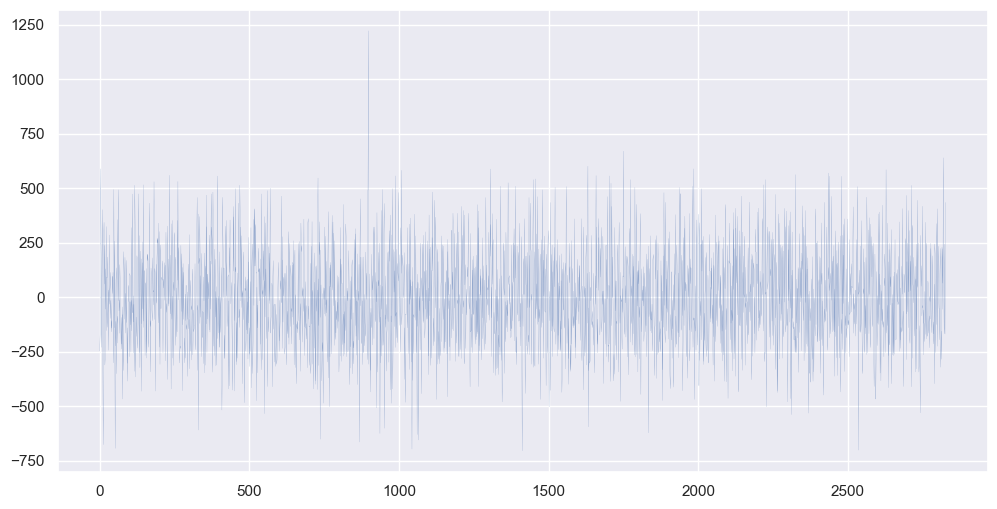

Residuals mean: -5.052677; Standard Deviation: 218.25
 Durbin Watson: 2.03


In [42]:
# Plotting the residuals
residuals_step = (y_test_step - y_pred_step).values

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(residuals_step, linewidth=0.1)
plt.show()
print(f'Residuals mean: {residuals_step.mean():.6f}; Standard Deviation: {residuals_step.std():.2f}'
    f'\n Durbin Watson: {durbin_watson(residuals_step):.2f}')
# closer to 2 means no autocorrelation; 0 or 4 means autocorrelation

ShapiroResult(statistic=0.9960682988166809, pvalue=9.086542149816523e-07)
NormaltestResult(statistic=22.40625375853073, pvalue=1.3631505284775091e-05)
KstestResult(statistic=0.5201152980327924, pvalue=0.0, statistic_location=-3.8693929031326206, statistic_sign=1)


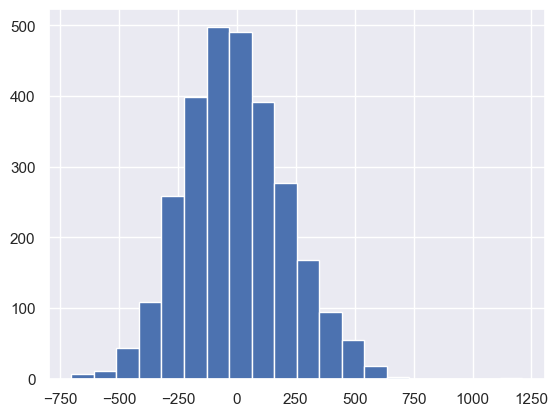

In [43]:
print(shapiro(residuals_step))
print(normaltest(residuals_step))
print(kstest(residuals_step, "norm"))
plt.hist(residuals, bins=20)
plt.show()

# Neural Network

In [44]:
# Create a model and displaying the summary
NN_model_a = MLPRegressor((100,100,100), max_iter=2000).fit(X_train, y_train)

y_pred_nn = NN_model_a.predict(X_test)

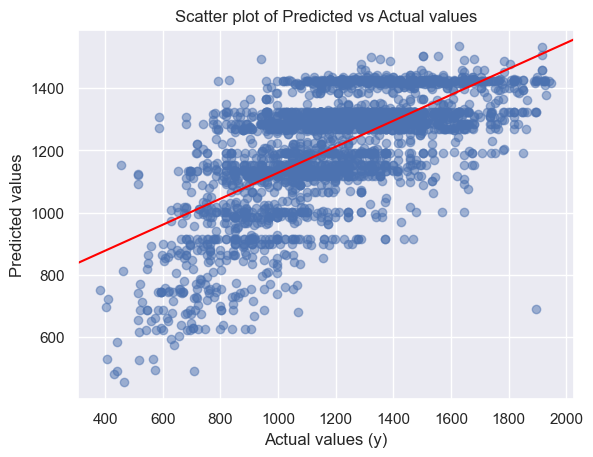

Model R squared: 0.4260

Prediction R squared: 0.4276 p-value: 0.0000

y = 0.4175x +710.5


In [45]:
# Create a scatter plot
m, b = np.polyfit(y_test, y_pred_nn, deg=1)
plt.scatter(y_test, y_pred_nn, alpha=0.5)
plt.title('Scatter plot of Predicted vs Actual values')
plt.xlabel('Actual values (y)')
plt.ylabel('Predicted values')
plt.axline(xy1=(y_test.mean(), y_test.mean() * m + b), slope=m, color='red')
plt.show()

print(f'Model R squared: {NN_model_a.score(X_test, y_test):.4f}\n')
R_2_step = pearsonr(y_test, y_pred_nn)
print(f'Prediction R squared: {R_2_step[0]**2:.4f} p-value: {R_2_step[1]:.4f}')
print(f'\ny = {m:.4f}x {b:+.1f}')

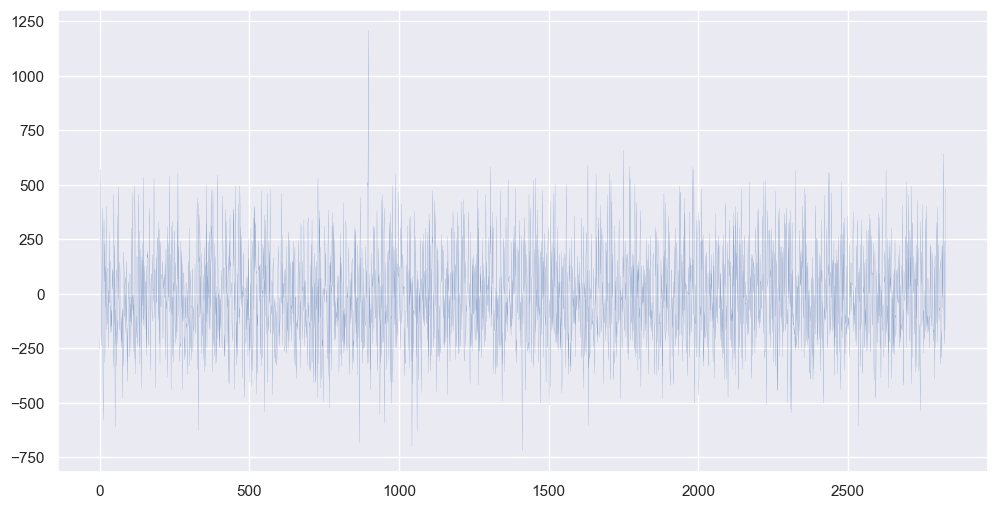

Residuals mean: -10.504278; Standard Deviation: 216.13
 Durbin Watson: 2.01


In [46]:
# Plotting the residuals
residuals_nn = (y_test - y_pred_nn).values

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(residuals_nn, linewidth=0.1)
plt.show()
print(f'Residuals mean: {residuals_nn.mean():.6f}; Standard Deviation: {residuals_nn.std():.2f}'
    f'\n Durbin Watson: {durbin_watson(residuals_nn):.2f}')
# closer to 2 means no autocorrelation; 0 or 4 means autocorrelation

ShapiroResult(statistic=0.9946796894073486, pvalue=1.4149283522613132e-08)
NormaltestResult(statistic=35.65506050345541, pvalue=1.8096808291181444e-08)
KstestResult(statistic=0.5397967723596534, pvalue=0.0, statistic_location=-3.267280380283637, statistic_sign=1)


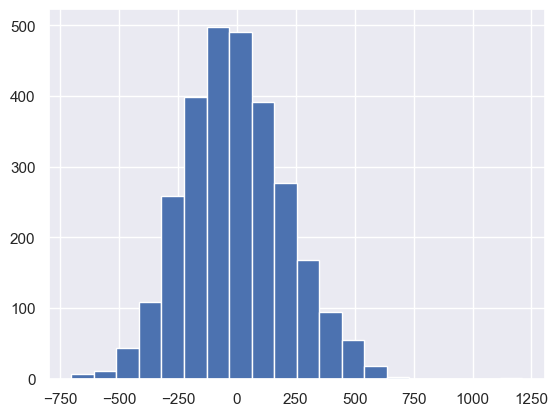

In [47]:
print(shapiro(residuals_nn))
print(normaltest(residuals_nn))
print(kstest(residuals_nn, "norm"))
plt.hist(residuals, bins=20)
plt.show()

# PCA

In [48]:
X_train = X_train.drop('const', axis=1)
X_test = X_test.drop('const', axis=1)

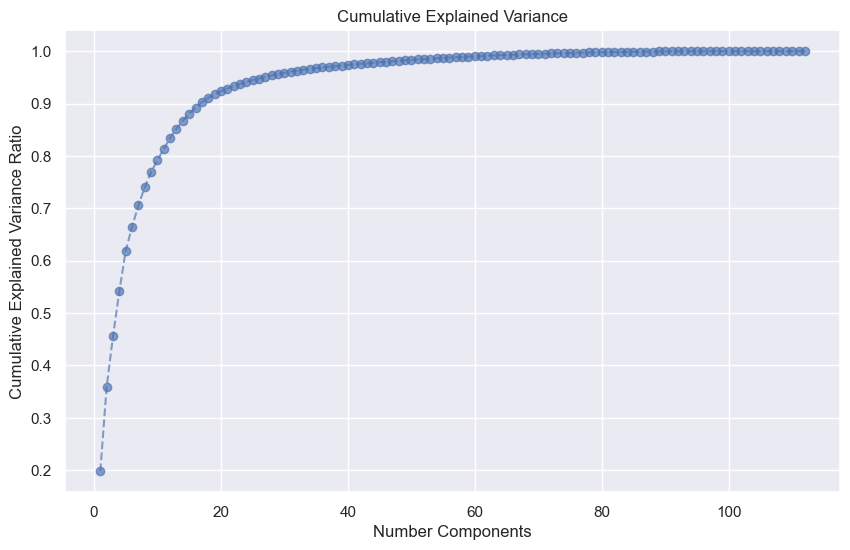

In [49]:
pca = PCA(n_components=X_train.shape[1]).fit(X_train) # fitted on train base only
X_pca_train = pca.transform(X_train) # Transforming train base
X_pca_test = pca.transform(X_test)   # Transforming test base

# Variance explained by each principal component
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, X_pca_train.shape[1] + 1), cumulative_variance_ratio, marker='o', linestyle='--', alpha=0.67)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [50]:
# Print the explained variance ratio for each component

pca_variance = pd.DataFrame({
    'Variance': pca.explained_variance_ratio_,
    'Cumulative Variance': pca.explained_variance_ratio_.cumsum(),
    'Eigenvalue': pca.singular_values_
    })
pca_variance['Component'] = pca_variance.index +1

pca_variance['Component'] = 'PC' + pca_variance['Component'].astype(str)
print(pca_variance[pca_variance.Eigenvalue >= 1].to_string())
print(pca_variance[pca_variance.Eigenvalue < 1].to_string())

    Variance  Cumulative Variance  Eigenvalue Component
0   0.198222             0.198222   73.492582       PC1
1   0.160798             0.359020   66.192364       PC2
2   0.096827             0.455847   51.364807       PC3
3   0.085817             0.541664   48.356563       PC4
4   0.077068             0.618732   45.825350       PC5
5   0.045971             0.664704   35.392547       PC6
6   0.040755             0.705459   33.324111       PC7
7   0.035016             0.740475   30.888634       PC8
8   0.028420             0.768894   27.827623       PC9
9   0.023143             0.792037   25.111935      PC10
10  0.021394             0.813431   24.144311      PC11
11  0.020792             0.834223   23.801929      PC12
12  0.018000             0.852224   22.146748      PC13
13  0.015024             0.867247   20.232863      PC14
14  0.013337             0.880584   19.063038      PC15
15  0.011487             0.892071   17.692036      PC16
16  0.010664             0.902736   17.046440   

In [51]:
components_df = pd.DataFrame(pca.components_, columns=X_train.columns).set_index(pca_variance['Component'])
components_df

,work_year,work_abroad,job_name_AI,job_name_Analyst,job_name_Analytics,job_name_Applied,job_name_Architect,job_name_Associate,job_name_Big,job_name_Database,...,company_location_MX,company_location_NG,company_location_NL,company_location_PL,company_location_PT,company_location_SI,company_location_UA,company_location_ZA,company_size_L,company_size_S
Component,,,,,,,,,,,,,,,,,,,,,
PC1,-0.968704,9.961573e-03,-5.638191e-03,-1.552451e-02,8.138232e-04,4.750475e-03,5.405004e-04,-8.424744e-04,1.759421e-03,-5.359722e-04,...,8.648461e-04,6.988832e-04,1.903319e-03,1.337403e-03,1.809372e-03,0.000523,-9.124690e-05,-0.001548,7.158586e-02,2.105816e-02
PC2,0.001365,-1.760465e-03,6.977775e-03,-1.251090e-01,4.589384e-02,-5.361921e-02,-1.014099e-02,-1.728142e-04,8.471086e-04,1.233739e-03,...,2.318725e-04,-5.525852e-04,-6.186660e-04,1.911424e-04,1.516505e-03,0.000092,6.325350e-05,0.000841,-3.393640e-02,-2.031429e-03
PC3,0.038113,1.494708e-03,-2.786367e-03,6.838457e-01,-1.719608e-03,-5.183439e-02,2.497999e-02,2.160105e-04,7.861630e-04,2.821810e-04,...,1.718279e-04,9.500813e-04,-2.097310e-04,7.163179e-04,-1.726398e-04,0.000747,9.548704e-05,0.000334,-6.376833e-02,3.977519e-03
PC4,-0.213315,-3.737384e-03,-9.759959e-04,2.293616e-01,-1.606265e-02,-1.657086e-02,-1.686898e-02,4.805733e-04,1.115567e-03,-1.705511e-03,...,-1.754487e-03,2.793275e-04,1.906608e-03,-1.989776e-03,7.489956e-04,0.000414,1.017336e-04,0.001537,5.926999e-02,9.623833e-04
PC5,0.020187,4.187646e-03,4.046945e-03,-1.375645e-01,2.690264e-02,2.869003e-03,-1.875449e-02,-2.157218e-07,8.124977e-04,1.683104e-03,...,9.474866e-04,2.210539e-04,1.974207e-04,1.780799e-03,1.240788e-03,0.001326,-6.838598e-04,-0.000230,1.645977e-02,7.090550e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC108,-0.000000,-4.894354e-18,6.521615e-19,5.565677e-19,2.758724e-18,2.999233e-17,-9.749830e-18,-7.021946e-17,4.681644e-17,-2.894656e-16,...,8.291256e-17,-1.458372e-16,-8.341670e-17,-2.725389e-18,1.435940e-16,0.319074,7.950029e-17,-0.167666,1.060718e-18,1.668308e-17
PC109,0.000000,-5.181314e-17,1.328795e-17,1.777714e-17,-2.195910e-17,-1.444165e-17,3.258925e-17,1.749997e-16,-8.353536e-17,-6.261522e-17,...,-1.764909e-16,1.129196e-16,1.885088e-17,-2.031602e-16,-1.571651e-16,0.335678,3.824872e-16,0.072405,4.711151e-18,-1.296291e-18
PC110,0.000000,1.639902e-17,-2.656190e-17,-1.160365e-17,-8.081232e-19,4.975926e-18,-2.188773e-17,2.251685e-16,-1.144581e-16,4.229730e-16,...,2.626465e-16,3.591376e-18,-3.808795e-17,-8.873892e-17,2.101695e-16,0.130586,4.240230e-16,-0.243211,2.723896e-19,2.822890e-17


In [52]:
# How many components have Eigenvalues larger than 1?
Eigen1 = pca_variance[pca_variance.Eigenvalue >= 1].shape[0]
Eigen1

95

In [53]:
pca_variance['Labels'] = pca_variance['Component'] + ":\n" + (pca_variance['Cumulative Variance']*100).round(1).astype(str) + '%'
pca_variance

,Variance,Cumulative Variance,Eigenvalue,Component,Labels
0,1.982219e-01,0.198222,7.349258e+01,PC1,PC1:\n19.8%
1,1.607979e-01,0.359020,6.619236e+01,PC2,PC2:\n35.9%
2,9.682686e-02,0.455847,5.136481e+01,PC3,PC3:\n45.6%
3,8.581740e-02,0.541664,4.835656e+01,PC4,PC4:\n54.2%
4,7.706836e-02,0.618732,4.582535e+01,PC5,PC5:\n61.9%
...,...,...,...,...,...
107,1.900861e-33,1.000000,7.196857e-15,PC108,PC108:\n100.0%
108,1.900861e-33,1.000000,7.196857e-15,PC109,PC109:\n100.0%
109,1.900861e-33,1.000000,7.196857e-15,PC110,PC110:\n100.0%
110,1.900861e-33,1.000000,7.196857e-15,PC111,PC111:\n100.0%


## Creating a PCA visualization plot
The main reason here is to understand each component's relation to the original variables

In [54]:
# Set cumulative variance milestones for the chart
reference_y_values = [.90, .95, .975, .99, .995, .999]
y_ticks = []
for val in reference_y_values:
    aux = pca_variance[pca_variance['Cumulative Variance'] > val]
    aux = aux.iloc[0, :]
    y_ticks.append(aux.name)
y_ticks

[16, 26, 41, 59, 70, 85]

In [55]:
# Count independent variables in categories to ease visualization
aux = []
for col in X_train.columns:
    aux.append(col[:9])
unique_entries = {}
for entry in set(aux):
    unique_entries[entry] = 0
for entry in aux:
    unique_entries[entry] = unique_entries[entry] + 1
unique_entries

{'company_l': 26,
 'experienc': 3,
 'employmen': 3,
 'employee_': 26,
 'remote_ra': 2,
 'work_abro': 1,
 'company_s': 2,
 'job_name_': 42,
 'work_year': 1,
 'salary_cu': 6}

In [56]:
# Set the limit for each new variables' category
limit_x_values = [1, 2, unique_entries['job_name_'] + 2]
for aux in ['experienc', 'employmen', 'salary_cu', 'employee_', 'remote_ra', 'company_l', 'company_s']:
    limit_x_values.append(max(limit_x_values) + unique_entries[aux])
del limit_x_values[-1:] #removing the last value as it's out of bounds for the DataFrame
print(limit_x_values)
[X_train.columns[i] for i in limit_x_values]

[1, 2, 44, 47, 50, 56, 82, 84, 110]


['work_abroad',
 'job_name_AI',
 'experience_level_EN',
 'employment_type_CT',
 'salary_currency_AUD',
 'employee_residence_AR',
 'remote_ratio_Hybrid',
 'company_location_AR',
 'company_size_L']

In [57]:
# based on the variable limits, position the ticks for a few variables for readability
xticks = [1, # work abroad
 round((limit_x_values[1] + limit_x_values[2])/2), # Job title in the middle
 limit_x_values[2],            # Experience level on one corner (will overlap with employment type, so that'll be skipped)
 limit_x_values[5]-1,                              # Currency on the other corner
 round((limit_x_values[5] + limit_x_values[7])/2), # Employee residence (middle)
 limit_x_values[7]-1,                              # Remote Ratio (middle)
 round(sum(limit_x_values[7:9])/2),                # Company Location (middle)
 limit_x_values[8]]                                # Company Size (middle)
[X_train.columns[i] for i in xticks]               # Review which variables will show

['work_abroad',
 'job_name_Principal',
 'experience_level_EN',
 'salary_currency_PLN',
 'employee_residence_IN',
 'remote_ratio_Remote',
 'company_location_IE',
 'company_size_L']

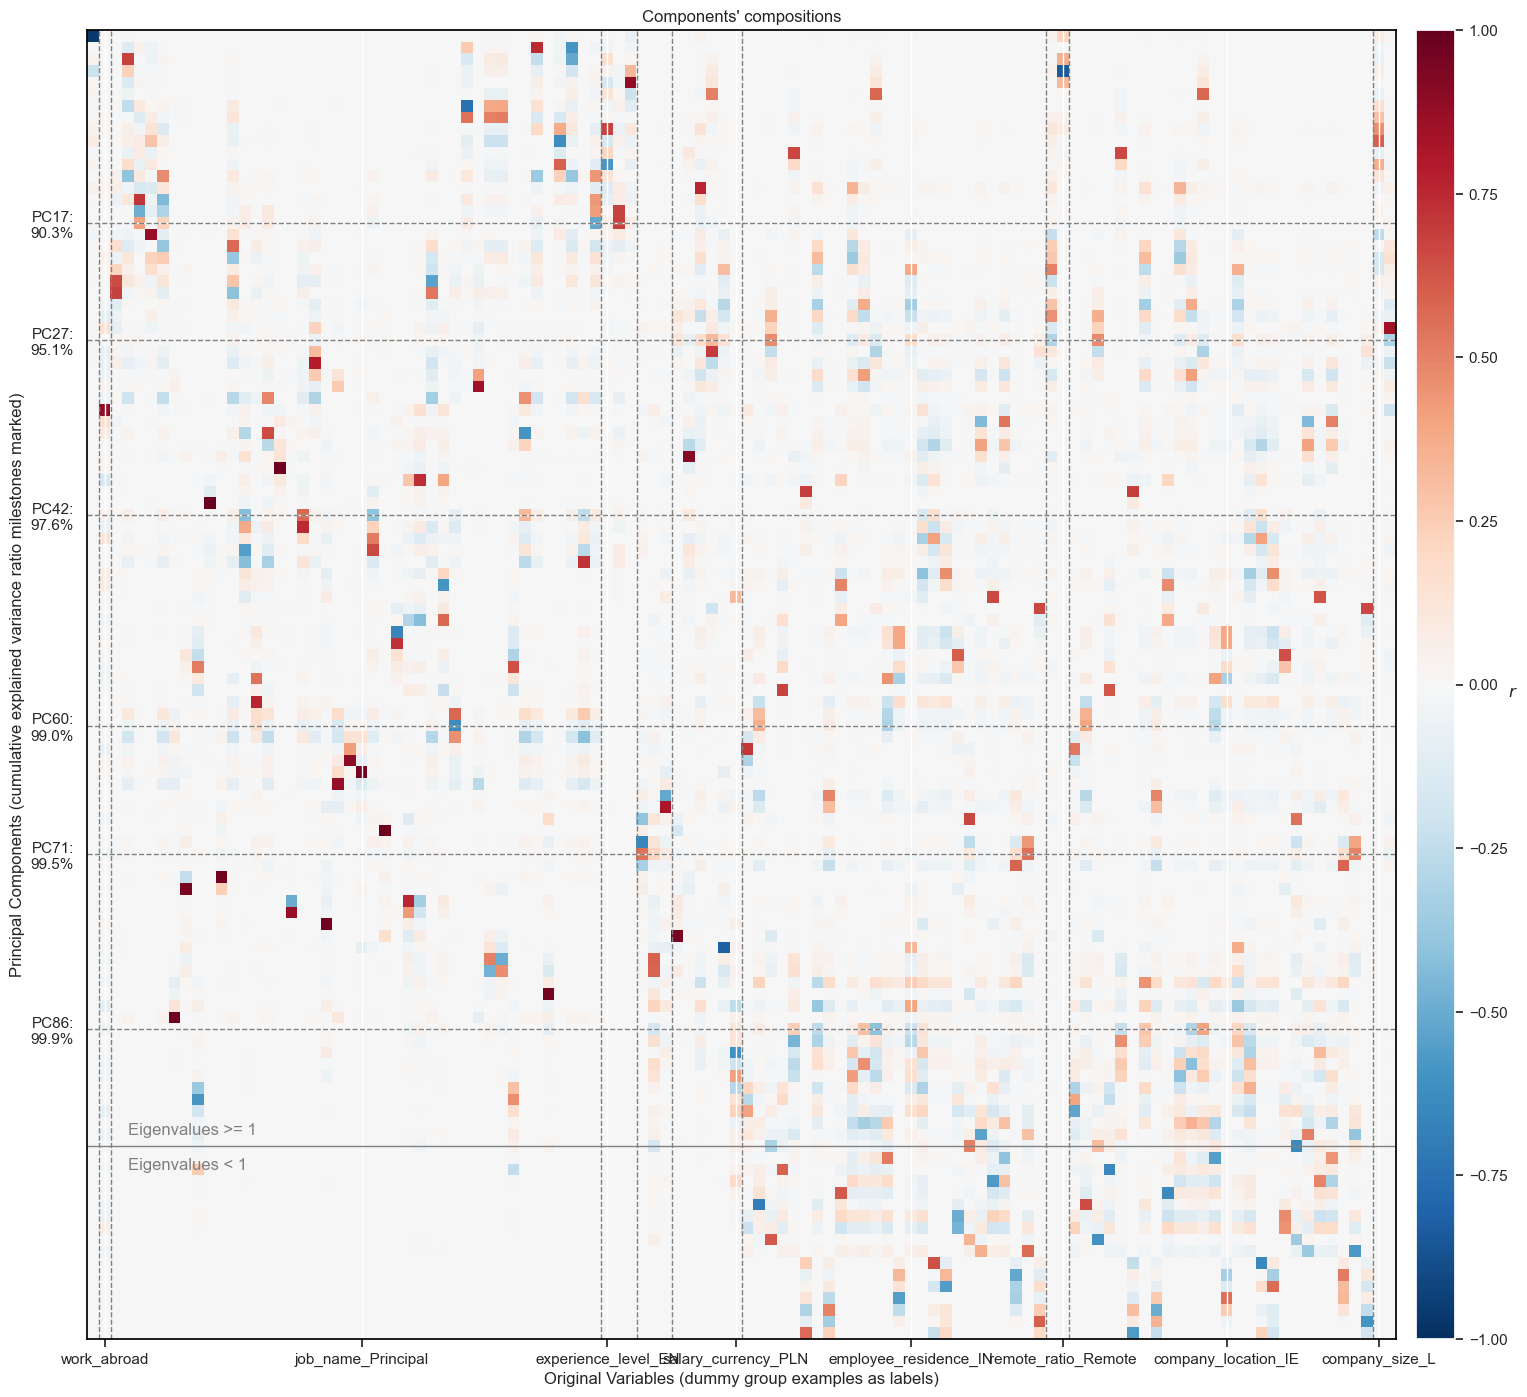

In [58]:
# Components' compositions heat matrix plot

fig, ax = plt.subplots(figsize=(18, 17))
im = ax.imshow(components_df, cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_title("Components' compositions")
plt.xlabel('Original Variables (dummy group examples as labels)')
plt.ylabel('Principal Components (cumulative explained variance ratio milestones marked)')

ax.tick_params(left=False, right=False, top=False, reset=True)
ax.set_xticks(xticks)
ax.set_xticklabels(components_df.columns[xticks])
for x_value in limit_x_values:
    plt.axvline(x=x_value-0.5, color='gray', linestyle='--', linewidth=1)

ax.set_yticks(y_ticks)
ax.set_yticklabels(pca_variance['Labels'][y_ticks])
for y_value in y_ticks:
    plt.axhline(y=y_value, color='gray', linestyle='--', linewidth=1)
    
plt.axhline(y=Eigen1, color='gray', linestyle='-', linewidth=1)
plt.annotate('Eigenvalues >= 1', xy=(0, Eigen1), xytext=(3, Eigen1-1), color="gray", size=12)
plt.annotate('Eigenvalues < 1', xy=(0, Eigen1), xytext=(3, Eigen1+2), color="gray", size=12)

cax = make_axes_locatable(ax).append_axes("right", size="3%", pad=0.2)
plt.colorbar(im, cax=cax).ax.set_ylabel("$r$", rotation=0)

[a.set_color("black") for a in ax.spines.values()]

plt.show()

In [59]:
# The naming used here is X_pca will be the original array and X_train_pca will be the dataframe derived from it
X_train_pca = pd.DataFrame(X_pca_train, columns = pca_variance['Component'].to_list())
X_train_pca.set_index(X_train.index, inplace=True)
X_train_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112
7627,-0.013035,-0.180568,0.044268,0.615991,0.594961,-0.292134,-0.024382,-0.137669,-0.254035,0.033607,...,0.000433,-0.000078,0.000348,-1.330520e-17,1.943167e-17,-2.208952e-18,-6.406317e-18,-2.242186e-18,-4.424595e-19,1.783344e-17
13498,1.046810,-0.721270,-0.531562,0.281872,-0.300457,-0.016785,-0.006143,-0.053956,-0.197953,-0.098400,...,-0.000003,0.000063,0.000135,2.957829e-18,-4.420775e-18,-2.967894e-18,6.567105e-18,-3.312799e-19,-3.103223e-19,4.064072e-18
4398,0.137684,-0.255750,1.252496,0.080051,0.762940,-0.439455,0.481607,0.915064,-0.172895,-0.408453,...,0.000409,-0.000154,-0.000549,1.011356e-17,1.921483e-17,2.847129e-19,-1.165490e-17,1.304506e-17,1.243922e-17,-1.745734e-17
12363,0.289874,-0.724069,-0.135652,-0.774511,0.043689,0.034263,0.006596,0.002503,-0.086076,-0.035461,...,-0.000040,0.000030,-0.000018,-1.378979e-18,-1.818690e-18,-2.859473e-18,6.458685e-18,2.541856e-18,2.725444e-18,1.461987e-18
12139,0.251507,-0.259722,1.063730,-0.353335,-0.139724,-0.082235,-0.164595,-0.083670,-0.132529,0.081303,...,0.000157,0.000055,-0.000104,4.692553e-18,1.010753e-17,-2.859473e-18,-9.153827e-18,4.222369e-18,-9.348189e-20,-5.910588e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,-0.019613,0.547849,-0.253931,0.532809,0.587669,-0.221141,0.136410,-0.416694,0.406939,-0.638261,...,0.000063,-0.000193,0.000036,-2.002726e-17,-3.444993e-18,9.352342e-19,-5.710536e-19,-3.245073e-18,7.027291e-19,-3.811568e-19
13418,1.307862,-0.180056,0.302983,-0.326981,-0.024641,-0.122826,0.261185,0.185936,0.099896,0.611315,...,-0.001164,-0.000304,0.000096,2.954796e-18,-1.652616e-18,-1.209868e-17,1.036568e-17,-5.791609e-18,-1.714459e-17,5.244500e-18
5390,0.074252,0.879575,-0.374951,0.116061,-0.330549,-0.026054,-0.518997,0.292466,-0.096734,-0.047838,...,0.000051,-0.000057,0.000141,9.246202e-18,-8.649164e-18,-4.054779e-20,-1.742130e-18,2.799354e-18,3.619911e-18,1.624617e-18
860,-0.997988,-0.278391,0.763636,0.606901,0.446763,-0.286445,-0.277887,-0.125226,-0.058021,0.114892,...,0.000234,-0.000084,-0.000128,-6.366309e-18,9.457013e-18,-3.835255e-18,-1.161049e-17,8.884843e-20,-4.454007e-18,3.738811e-18


In [60]:
X_train_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112
count,1.131400e+04,1.131400e+04,1.131400e+04,1.131400e+04,1.131400e+04,1.131400e+04,1.131400e+04,1.131400e+04,1.131400e+04,1.131400e+04,...,1.131400e+04,1.131400e+04,1.131400e+04,1.131400e+04,1.131400e+04,1.131400e+04,1.131400e+04,1.131400e+04,1.131400e+04,1.131400e+04
mean,2.193739e-14,-1.155558e-16,-9.454853e-16,4.872774e-15,-5.237693e-16,-6.346150e-16,-1.295293e-16,-3.252363e-16,-9.250746e-16,-1.769174e-15,...,-4.881880e-19,-5.446118e-19,3.294656e-18,7.917072e-19,1.794959e-19,8.807864e-20,-1.943534e-19,8.226939e-20,1.945417e-19,-8.718062e-20
std,6.909627e-01,6.223275e-01,4.829218e-01,4.546388e-01,4.308409e-01,3.327537e-01,3.133067e-01,2.904088e-01,2.616298e-01,2.360974e-01,...,5.360087e-03,3.887924e-03,3.407473e-03,3.189684e-17,3.532477e-17,2.081869e-17,3.101413e-17,2.713754e-17,2.632073e-17,2.988332e-17
min,-1.043221e+00,-8.762384e-01,-8.898969e-01,-1.052611e+00,-6.623373e-01,-5.795191e-01,-8.956099e-01,-4.173557e-01,-5.757372e-01,-9.346322e-01,...,-1.497887e-01,-2.082723e-01,-9.582460e-02,-3.999317e-16,-5.137790e-16,-2.779216e-16,-3.457852e-16,-4.624982e-16,-3.314867e-16,-5.921785e-16
25%,-6.826843e-01,-7.199045e-01,-3.749510e-01,-3.533351e-01,-2.915005e-01,-1.312954e-01,-1.645950e-01,-2.071323e-01,-1.465988e-01,-4.783833e-02,...,-3.171263e-05,-1.094780e-04,-6.213028e-05,-5.715788e-18,-5.396557e-18,-2.967894e-18,-6.406317e-18,-1.591665e-18,-1.834982e-18,-3.037452e-18
50%,7.425164e-02,-1.651283e-01,-1.612242e-01,9.005052e-02,-2.415307e-01,-1.941361e-02,6.595701e-03,-5.940663e-02,-7.410172e-02,1.707222e-02,...,5.281069e-05,2.985955e-05,2.381177e-05,5.725846e-19,-2.252371e-18,-7.994893e-19,-1.547471e-18,8.884843e-20,9.839440e-19,1.461987e-18
75%,2.649720e-01,6.148002e-01,1.584585e-01,2.980126e-01,8.537843e-02,1.372778e-02,2.187411e-01,5.315631e-02,3.777487e-02,8.130343e-02,...,1.565133e-04,1.104761e-04,9.970741e-05,9.246202e-18,6.746507e-18,3.754160e-18,6.458685e-18,2.799354e-18,3.619911e-18,4.064072e-18
max,3.313210e+00,8.888132e-01,1.429028e+00,1.582493e+00,1.343464e+00,1.821115e+00,1.156326e+00,1.404604e+00,1.721670e+00,9.416336e-01,...,2.994630e-01,3.276949e-01,2.446574e-01,3.193958e-16,9.778664e-16,2.619876e-16,5.850464e-16,5.247072e-16,4.362742e-16,5.017007e-16


In [61]:
#Applying the same transformation to the test base
X_test_pca = pd.DataFrame(X_pca_test, columns = pca_variance['Component'].to_list())
X_test_pca.set_index(X_test.index, inplace=True)

# PCA Model

### Only those with eigenvalues > 1 are selected

In [62]:
components = X_train_pca.columns[:Eigen1]
X_train_eigen1 = X_train_pca[components]
X_train_eigen1 = sm.add_constant(X_train_eigen1)
X_test_eigen1 = X_test_pca[components]
X_test_eigen1 = sm.add_constant(X_test_eigen1)

In [63]:
# Create a model with PCA cols
MRL_model_PCA = sm.OLS(y_train, X_train_eigen1).fit()
MRL_model_PCA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     86.99
Date:                Sun, 17 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:55:52   Log-Likelihood:                -76778.
No. Observations:               11314   AIC:                         1.537e+05
Df Residuals:                   11218   BIC:                         1.545e+05
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1209.0330      2.023    597.653      0.000    1205.068    1212.998
PC1          -18.3254      2.928     -6.259      0.000     -24.065     -12.586
PC2           43.0258      3.251     13.235      0.000      36.654      49.398
PC3         -207.5911      4.189    -49.554      0.000    -215.803    -199.380
PC4         -134.0533      4.450    -30.126      0.000    -142.776    -125.331
PC5         -123.6364      4.696    -26.330      0.000    -132.841    -114.432
PC6         -110.4465      6.080    -18.166      0.000    -122.364     -98.529
PC7          -54.8736      6.457     -8.498      0.000     -67.531     -42.216
PC8            8.9981      6.966      1.292      0.196      -4.657      22.653
PC9         -191.6350      7.733    -24.783      0.000    -206.792    -176.478
PC10         -31.2625      8.569     -3.648      0.000     -48.059     -14.466
PC11        -106.7884      8.912    -11.982      0.000    -124.258     -89.319
PC12         214.3870      9.040     23.714      0.000     196.666     232.108
PC13           8.2260      9.716      0.847      0.397     -10.819      27.271
PC14        -316.5459     10.635    -29.764      0.000    -337.392    -295.699
PC15         -57.7445     11.288     -5.116      0.000     -79.870     -35.619
PC16          58.1954     12.162      4.785      0.000      34.355      82.036
PC17         135.1355     12.623     10.705      0.000     110.392     159.879
PC18          92.2108     14.373      6.416      0.000      64.038     120.384
PC19        -126.9721     16.063     -7.904      0.000    -158.459     -95.485
PC20         101.3257     16.671      6.078      0.000      68.647     134.004
PC21        -177.7902     18.566     -9.576      0.000    -214.183    -141.398
PC22         218.7475     19.111     11.446      0.000     181.286     256.209
PC23          67.9780     20.319      3.345      0.001      28.148     107.808
PC24         112.2651     20.750      5.410      0.000      71.591     152.939
PC25         158.5778     22.539      7.036      0.000     114.397     202.759
PC26         -99.4802     23.202     -4.288      0.000    -144.961     -54.000
PC27        -173.2102     23.761     -7.290      0.000    -219.785    -126.635
PC28        -169.1280     24.278     -6.966      0.000    -216.717    -121.539
PC29         170.6072     25.182      6.775      0.000     121.247     219.968
PC30         146.7826     26.527      5.533      0.000      94.785     198.780
PC31        -170.3884     26.714     -6.378      0.000    -222.753    -118.024
PC32          19.9504     30.066      0.664      0.507     -38.983      78.884
PC33         -69.1427     31.950     -2.164      0.030    -131.770      -6.516
PC34        -110.6905     32.825     -3.372      0.001    -175.033     -46.348
PC35         146.4501     34.891      4.197      0.000      78.057     214.843
PC

In [64]:
y_pred_eigen1 = MRL_model_PCA.predict(X_test_eigen1)

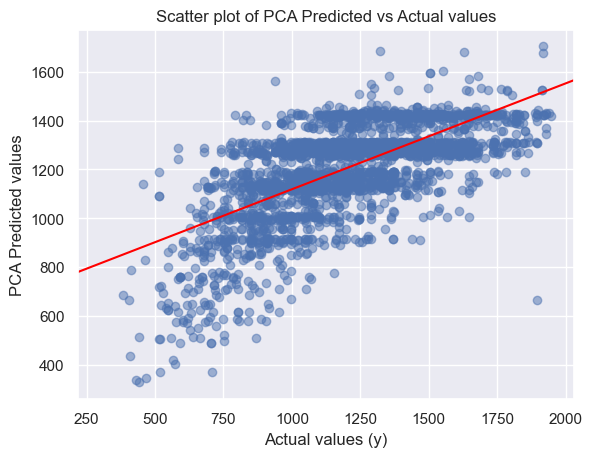

Model R squared: 0.4242

Prediction R squared: 0.4275 p-value: 0.0000

y = 0.4341x +684.8


In [65]:
# Create a scatter plot
m, b = np.polyfit(y_test, y_pred_eigen1, deg=1)

plt.scatter(y_test, y_pred_eigen1, alpha=0.5)
plt.title('Scatter plot of PCA Predicted vs Actual values')
plt.xlabel('Actual values (y)')
plt.ylabel('PCA Predicted values')
plt.axline(xy1=(300, 300 * m + b), slope=m, color='red')
plt.show()

print(f'Model R squared: {MRL_model_PCA.rsquared:.4f}\n')
R_2_eigen1 = pearsonr(y_test, y_pred_eigen1)
print(f'Prediction R squared: {R_2_eigen1[0]**2:.4f} p-value: {R_2_eigen1[1]:.4f}')
print(f'\ny = {m:.4f}x {b:+.1f}')

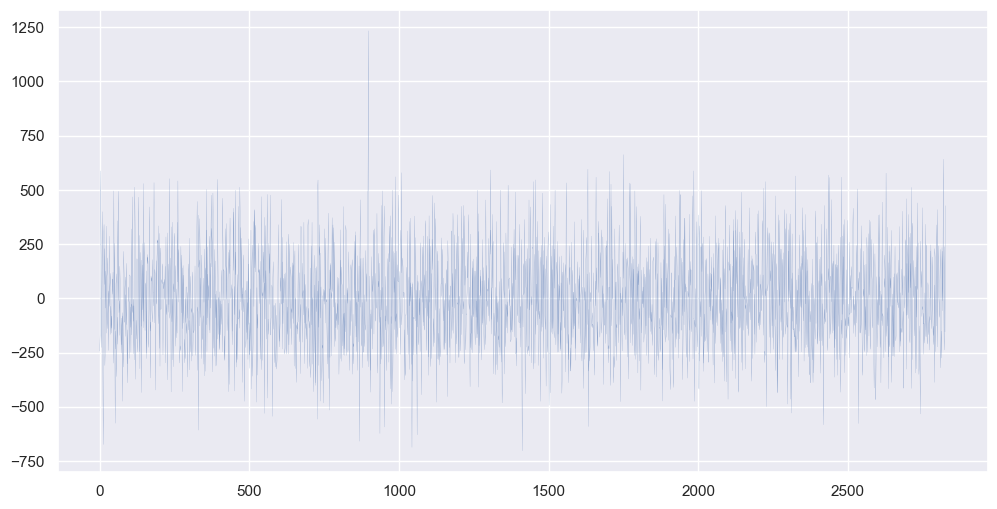

Residuals mean: -4.846718; Standard Deviation: 216.12
 Durbin Watson: 2.01


In [66]:
# Plotting the residuals
residuals_eigen1 = (y_test - y_pred_eigen1).values

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(residuals_eigen1, linewidth=0.1)
plt.show()
print(f'Residuals mean: {residuals_eigen1.mean():.6f}; Standard Deviation: {residuals_eigen1.std():.2f}'
    f'\n Durbin Watson: {durbin_watson(residuals_eigen1):.2f}')
# closer to 2 means no autocorrelation; 0 or 4 means autocorrelation

ShapiroResult(statistic=0.9950433373451233, pvalue=3.9515906991027805e-08)
NormaltestResult(statistic=32.98615760048146, pvalue=6.873008602060882e-08)
KstestResult(statistic=0.5274209630126575, pvalue=0.0, statistic_location=-3.2721083516034923, statistic_sign=1)


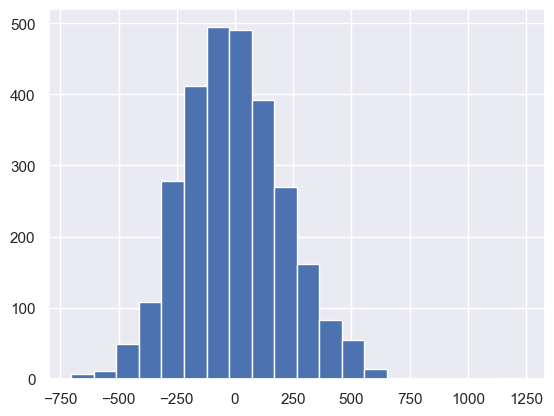

In [67]:
print(shapiro(residuals_eigen1))
print(normaltest(residuals_eigen1))
print(kstest(residuals_eigen1, "norm"))
plt.hist(residuals_eigen1, bins=20)
plt.show()